# RNN Pseudocode

Given : 

1. Wxh - input to hidden weight
2. Whh - hidden to hidden weight
3. bh - hidden bias
4. Wo - hidden to output weight
5. bo - output bias
6. X - TxD input matrix

<br>

__tanh hidden__ activation<br>
__softmax output__ activation

```python
Yhat = []
h_last = h0
for t in range(T):
    h_t = tanh(X[t].dot(Wx) + h_last.dot(Wh) + bh)
    yhat = softmax(h_t.dot(Wo) + bo)
    yhat.append(yhat)
    
    # important, don't forget to udpate h_last
    h_last = h_t
```

## Steps
1. Load in the data
    - Same as before, but not the right shape for our RNN (N x T x D)
2. Build the model
3. Train the model
4. Evaluate the model
5. Make Predictions

### Building the model
```python
class SimpleRNN(nn.Module):
    def __init__(self, ...):
        self.rnn = nn.RNN(
            input_size=num_inputs,
            hidden_size=num_hidden,
            num_layers=num_layers,
            nonliniearity='relu',
            batch_first=True)
```

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

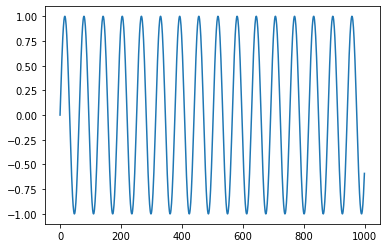

In [2]:
N = 1000
series = np.sin(0.1 * np.arange(N))

plt.plot(series)

In [5]:
### Build The Dataset
# Let's see if we can use T past values to predict the next value
T = 10
X = []
Y = []
for t in range(len(series)-T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

In [8]:
np.array(X).shape

(990, 10)

In [9]:
np.array(Y).shape

(990,)

In [10]:
X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1,1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (990, 10, 1) Y.shape (990, 1)


In [12]:
X[0]

array([[0.        ],
       [0.09983342],
       [0.19866933],
       [0.29552021],
       [0.38941834],
       [0.47942554],
       [0.56464247],
       [0.64421769],
       [0.71735609],
       [0.78332691]])

In [13]:
# Set Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
### Define Simple RNN
class SimpleRNN(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    